<a href="https://colab.research.google.com/github/awest93/classification-tasks-and-EDA-example/blob/main/classification_tasks_and_EDA_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Обнаружение фальшивых новостей

Выполнение задачи будет осуществлятся в несколько шагов:

1.1. Загрузка файла;

1.2. Чтение данных из загруженного файла с последующей заменой строковых обозначений классов (Fake и Real), на числовые обозначения через словарь;

1.3. Разбиение выборки на учебную и тестовую. В выборку для обучения войдут первые 4500 тысячи записей, а остальные 1835 записей войдут в выборку для проверки результатов;

1.4. Тексты будут разбиты на набора признаков для дальнейшего обучения классификатора;

1.5. Обучение пассивно-агрессивного классификатора с параметрами по умолчанию;

1.6. Далее на основе предсказаний обученного классификатора строится матрица ошибок.



---


1.1. Импорт библиотек и загрузка файла;

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv

--2023-12-09 08:45:13--  https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30696129 (29M) [text/csv]
Saving to: ‘fake_news.csv’

fake_news.csv       100%[===================>]  29.27M  17.0MB/s    in 1.7s    

2023-12-09 08:45:15 (17.0 MB/s) - ‘fake_news.csv’ saved [30696129/30696129]



1.2. Чтение данных из загруженного файла с последующей заменой строковых обозначений классов (Fake и Real), на числовые обозначения через словарь;

In [ ]:
df = pd.read_csv("./fake_news.csv")

categories = {
    "FAKE":0,
    "REAL":1
}

df = df.replace({"label": categories})

1.3. Разбиение выборки на учебную и тестовую. В выборку для обучения войдут первые 4500 тысячи записей, а остальные 1835 записей войдут в выборку для проверки результатов;

In [ ]:
trainLabels=df.loc[0:4500, 'label']
trainTexts=df.loc[0:4500, 'text']

testLabels=df.loc[4500:, 'label']
testTexts=df.loc[4500:, 'text']

1.4. Тексты будут разбиты на набора признаков для дальнейшего обучения классификатора;

In [ ]:
vectorizer = TfidfVectorizer(
    sublinear_tf = True, max_df=0.5, min_df=5, stop_words="english"
)
featuredTextTrain = vectorizer.fit_transform(trainTexts)
featuredTextTest = vectorizer.transform(testTexts)

1.5. Инициализация пассивно-агрессивного классификатор с параметрами по умолчанию, его обучение и генерация предсказаний для тестового набора текстов;

In [ ]:

clf = PassiveAggressiveClassifier()
clf.fit(featuredTextTrain, trainLabels)
pred = clf.predict(featuredTextTest)

1.6. На основе предсказаний обученного классификатора строится матрица ошибок.

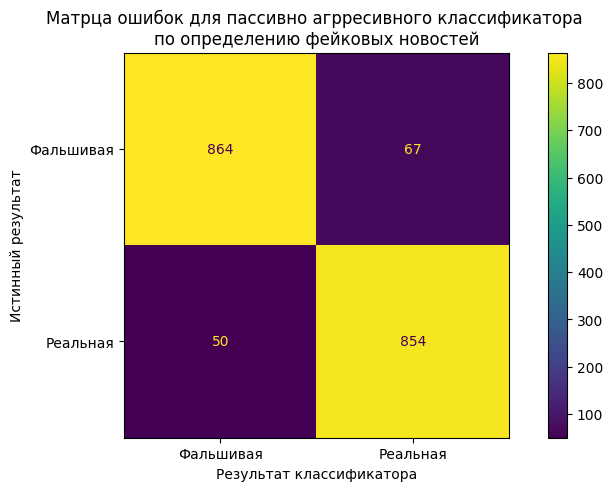

In [ ]:
categories = {
    "Фальшивая":0,
    "Реальная":1
}
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(testLabels, pred, ax=ax)
ax.xaxis.set_ticklabels(categories.keys())
ax.yaxis.set_ticklabels(categories.keys())
ax.set_xlabel("Результат классификатора")
ax.set_ylabel("Истинный результат")
_ = ax.set_title(
    f"Матрца ошибок для пассивно агрресивного классификатора \nпо определению фейковых новостей"
)

In [ ]:
accuracy_score(testLabels, pred)

0.9362397820163487

Как следует из графика и вывода выше классификатор работает хорошо, подавляющее количество предсказаний верно, а общая точность составляет примерно 93 процента.



---

Дополнительная информация

В качестве дополнительной информации будут получены 5 признаков текста имеющих наибольший вес при решении об отнесении статьи к категоии фейковых или реальных, а также выполнено визуальное отображение этих признаков со степенью их влияния на решение о классификации.

5 самых влиятельных признаков текста по группам:
    Реальная Фальшивая
0      obama  november
1  president  election
2   campaign   october
3      state   hillary
4        gop      2016


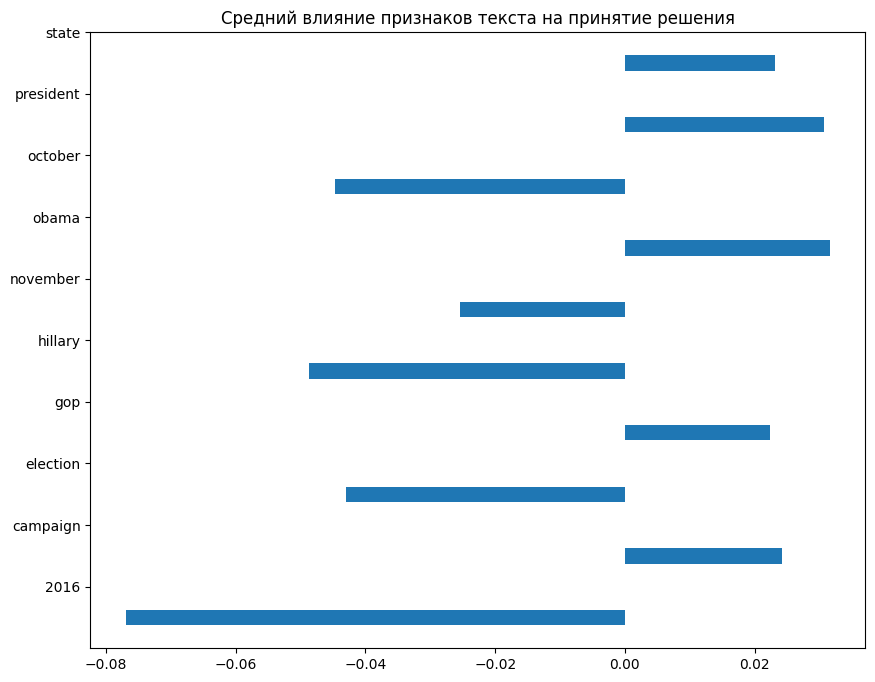

In [ ]:
def plot_feature_effects():
    feature_names = vectorizer.get_feature_names_out()
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(featuredTextTrain.mean(axis=0)).ravel()

    top5 = np.argsort(average_feature_effects[0])[-5:][::-1]
    top = pd.DataFrame(feature_names[top5], columns=["Реальная"])
    top_indices_real = top5

    top5 = np.argsort(average_feature_effects[0])[0:5][::-1]
    top["Фальшивая"] = feature_names[top5]
    top_indices_fake = top5

    top_indices = np.concatenate((top_indices_real, top_indices_fake), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.0
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(
        y_locs + (0 - 2) * bar_size,
        average_feature_effects[0][top_indices],
        height=bar_size,
    )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )

    print("5 самых влиятельных признаков текста по группам:")
    print(top)

    return ax

_ = plot_feature_effects().set_title("Средний влияние признаков текста на принятие решения")

На грфике отрицательные значения указывают на то, что признак имеет некоторую степень веса при определении новости как фейковой, а положительные указывают что признак относится к реальным новостям.

Из таблицы и графика выше следует что в фейковых новостях часто упоминаются 2016 год, Хиллари Клинтон, выборы, ноябрь и октябрь. В правдивых новостях чаще всего упоминается кампания (скорее всего, президентская), GOP, Барак Обама, президент и государство.

При этом упоминания и Хиллари Клинтон оказывали наибольшее влияние на решение классификатора о принадлежности статьи к категории фейковых. В то же время упоминания Барака Обамы и президента, оказывали наибольшее влияние на решение классификатора о принадлежности статьи к категории реальных новостей.

---


#2. Обнаружение болезни паркинсона с помощью XGBoost

Выполнение задачи будет осуществлятся в несколько шагов:

2.1. Загрузка файлов;

2.2. Чтение данных из загруженного файла, и создание массива с данными для обучения и массива с указанием на принадлежность данных к определённому классу (болен/здоров);

2.3. Разбиение выборки на учебную и тестовую;

2.4. Нормализация данных для обучения;

2.5. Обучение модели;

2.6. Построение матрицы ошибок.

2.1. Загрузка файлов;

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data
!wget https://storage.yandexcloud.net/academy.ai/practica/parkinsons.names

--2023-12-09 11:45:38--  https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40697 (40K) [application/x-www-form-urlencoded]
Saving to: ‘parkinsons.data’

parkinsons.data     100%[===================>]  39.74K  --.-KB/s    in 0.1s    

2023-12-09 11:45:39 (335 KB/s) - ‘parkinsons.data’ saved [40697/40697]

--2023-12-09 11:45:39--  https://storage.yandexcloud.net/academy.ai/practica/parkinsons.names
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3080 (3.0K) [application/x-www-form-urlencoded]
Saving to: ‘parkinsons.names’

parkins

2.2. Чтение данных из загруженного файла, и создание массива с данными для обучения и массива с указанием на принадлежность данных к определённому классу (болен/здоров). Признак принадлежности к классу хранится в поле "status". Также из массива с данными для обученя следует удалить поля не относящиеся к данным влияющим на классификацию - "name", "status";

In [ ]:
df = pd.read_csv("./parkinsons.data")

allLabels = df.loc[0:, 'status']
allData = df.drop(['status','name'], axis=1)

2.3. Разбиение выборки на учебную и тестовую. Разбиение выполняется в соотношении 80/20 с перемешиванием элементов, а также с сохранением соотношения классов. Сохранение соотношения необходимо из-за того что в выборке очень неравномерно представлены классы "болен"/"здоров", с сильным преобладанием данных класса "больной";

In [ ]:
trainData, testData, trainLabels, testLabels = train_test_split(allData, allLabels, test_size=0.20, shuffle = True, stratify = allLabels, random_state=23)

2.4. Нормализация данных для обучения. Для нормализации значений будет применён метод перевода значения столбца в его отношение к максимальному значению в этом столбце и минимальному. Таким образом можно добиться значений в диапазоне [0,1]. Это следует сделать, так как в наборе данных есть поля значения которых выходят за рамки приведённого диапазона, и это может неганивно сказаться на сходимости модели;

In [ ]:
scaler = MinMaxScaler()
trainData = scaler.fit_transform(trainData)
testData = scaler.fit_transform(testData)

2.5. Обучение модели. Используется классификатор XGBoost с параметрами по умолчанию;

In [ ]:
bst = XGBClassifier()
bst.fit(trainData, trainLabels)
preds = bst.predict(testData)

2.6. Построение матрицы ошибок.

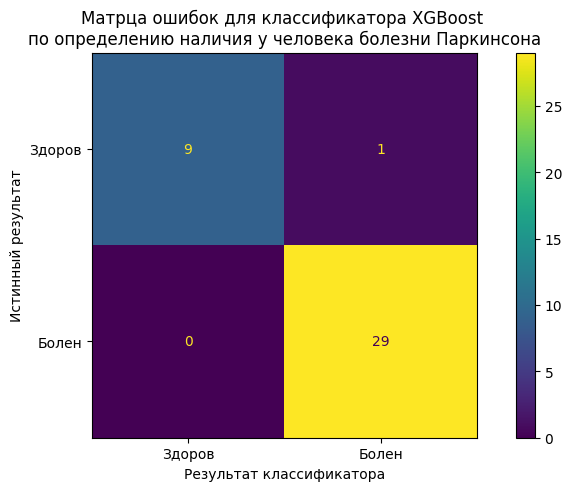

In [ ]:
categories = {
    "Здоров":0,
    "Болен":1
}
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(testLabels, preds, ax=ax)
ax.xaxis.set_ticklabels(categories.keys())
ax.yaxis.set_ticklabels(categories.keys())
ax.set_xlabel("Результат классификатора")
ax.set_ylabel("Истинный результат")
_ = ax.set_title(
    f"Матрца ошибок для классификатора XGBoost \nпо определению наличия у человека болезни Паркинсона"
)

In [ ]:
accuracy_score(testLabels, preds)

0.9743589743589743

Как видно из графиков и вывода классификатор обеспечивает выокий уровень точности в 97 процентов.

---


#3. Задача исследовательского анализа данных о винах и кластеризацию данных о качестве вина

Подробное описание задачи.

В рамках данный работы ставится задача исследования качества вина от его характеристик. Решение задачи выполняется посредством анализа зависимостей качества вина от других параметров на графиках и кластеризации набора данных с последующим анализом полученных кластеров.

Этапы решения задачи включают:
* Предварительную обработку данных;
* Исследовательский анализ данных;
* Подготовку к решению задачи кластеризации (нормализация и понижение размерности данных);
* Выбор и применение методов кластеризации;
* Оценку и визуализацию результатов.

> Предварительная обработка данных

При предварительной обработке данных выполняется анализ набора данных на пустые значения, дубликаты, а также значения параметров. По результатам выполняются операции удаления пустых значений и дубликатов из набора.

> Исследовательский анализ данных

В рамках исследовательского анализа выполняется проверка зависимости качества вина от его характеристик, посредством построения графиков зависимости качества вина от его параметров и их анализа. Также выполняется исследование остальных значений набора данных на корреляцию между собой, посредством построения матрицы корреляции, графиков корреляции и их анализа.

> Подготовка к решению задачи кластеризации

Для кластеризации набора данных выполняется понижение размерности данных с использованием метода главных компонент (Principal component analysis). Для корректности результатов метода декомпозиции, предварительнос выполняется нормализация данных методом стандартного масштабирования (Standard scaler).

> Применение методов кластеризации

Для кластеризации набора данных используются 4 метода:

- Гауссово смешение (GaussianMixture)
- метод k средних (KMeans)
- Спектральная кластеризация (SpectralClustering)
- Кластеризация WARD (WARD Clustering)

По результатам кластеризации строятся графики полученных кластеров для всех методов и выполняется оценка выполненной кластеризации.

> Оценка и визуализация результатов

Для проверки того насколько хорошо полученные кластеры накладываются на набор данных выполняется построение графика кластеров полученных одним из методов и графика данных с пониженной размерностью с указанием метки качества вина. После построение графиков выполняется их анализ.

##3.1. Загрузка файла с набором данных

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget https://raw.githubusercontent.com/milaan9/Clustering-Datasets/master/01.%20UCI/wineqr.csv

--2023-12-20 14:12:16--  https://raw.githubusercontent.com/milaan9/Clustering-Datasets/master/01.%20UCI/wineqr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84143 (82K) [text/plain]
Saving to: ‘wineqr.csv’

wineqr.csv          100%[===================>]  82.17K  --.-KB/s    in 0.002s  

2023-12-20 14:12:16 (47.2 MB/s) - ‘wineqr.csv’ saved [84143/84143]



##3.2. Чтение данных из загруженного файла и их предварительная обработка

In [ ]:
df = pd.read_csv("./wineqr.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
len(df[df.duplicated()])

240

В наборе присутствует некоторое количество дубликатов, которые следует удалить из набора перед дальнейшими операциями. Также, на всякий случай, выполнится команда удаления нулевых значений.

In [ ]:
df=df.drop_duplicates()
df=df.dropna()

##3.3. Исследовательский анализ данных

В рамках задачи следует выполнить построение графиков зависимости качества от остальных параметров алкоголя и выполнить их анализ.

In [ ]:
fig = px.scatter(df, y='quality', x='alcohol', color='quality')
fig.show()

Как следует из графика, наблюдается зависимость количества алкоголя в вине от его качества. Вина крепче 12 градусов имеют хорошее качество (больше 5), в то время как среди менее крепких вин можно часто найти вина низкого качества.

In [ ]:
fig = px.scatter(df, y='quality', x='sulphates', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от содержания в нём сульфатов. Среди вин с содержанием сульфатов от 0.4 до 0.8 сосредоточена основная масса вин низкого качества (3-4). Количество вин хорошего качества (7-8) больше всего при концентрации сульфатов от 0.6 до 1. Вина среднего качества распределены по содержанию сульфатов равномерно.

In [ ]:
fig = px.scatter(df, y='quality', x='pH', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от его водородного показателя. Среди вин с pH от 3.2 до 3.6 встречается больше всего вин низкого качества (3-4). Вина хорошего качества (7-8) в основном встречаются при показателе pH от 3.0 до 3.4. Вина среднего качества распределены по уровню pH равномерно.

In [ ]:
fig = px.scatter(df, y='quality', x='density', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от его показателя плотности. Большинство вин из набора данных имеет плотность от 0.994 до 1 и в этом же диапазоне сконцентрирована основная масса вин низкого качества (3-4). Вина хорошего качества (7-8) почти не встречаются при плотности выше 1, однако, некоторое количество такого вина можно заметить с плотностью от 0.990 до 0.994.  Вина среднего качества распределены по уровню плотности относительно равномерно.

In [ ]:
fig = px.scatter(df, y='quality', x='total sulfur dioxide', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от общего содержания диоксида серы. Основная масса вин хорошего (7-8) и низкого (3-4) качества имеют в составе от 0 до 50 единиц диоксида серы суммарно. При этом вина среднего качества (5-6) встречаются с практически любым общим содержанием диоксида серы.

In [ ]:
fig = px.scatter(df, y='quality', x='free sulfur dioxide', color='quality')
fig.show()

Из графика свободного диоксида серы можно выделить ту же зависимость что и в случае с общим содержанием диоксида серы. Основная масса вин хорошего (7-8) и низкого (3-4) качества имеют в составе от 0 до 30 единиц свободного диоксида серы. При этом вина среднего качества (5-6) встречаются с практически любым содержанием свободного диоксида серы.

In [ ]:
fig = px.scatter(df, y='quality', x='chlorides', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от содержания в нём хлоридов (различных ионов таких как хлорид калия, хлорид кальция и др.). У основной массы всех вин этот показатель находится на низком уровне (0-0.1). Однако, большое количество вин среднего качества (5-6) имеют хлориды в составе в количестве превышающем 0.1.

In [ ]:
fig = px.scatter(df, y='quality', x='residual sugar', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от содержания в нём остатков сахара. У основной массы всех вин этот показатель находится ниже 4. Однако, большое количество вин среднего качества (5-6) имеют в составе значение сахара превышающее 4.

In [ ]:
fig = px.scatter(df, y='quality', x='citric acid', color='quality')
fig.show()

Из графика не получается выделить какую-либо зависимость качества вина от содержания в нём лимонной кислоты.

In [ ]:
fig = px.scatter(df, y='quality', x='volatile acidity', color='quality')
fig.show()

Из графика можно выделить некоторую зависимость качества вина от его летучей кислотности. Среди вин с летучей кислотностью от 0.2 до 0.6 встречается больше всего вин хорошего качества (7-8). Также, вероятность встретить вино низкого качества (3-4) с летучей кислотность от 0.2 до 0.4 достаточно мала. Вина среднего качества (5-6) распределены по уровню летучей кислотности равномерно.

In [ ]:
fig = px.scatter(df, y='quality', x='fixed acidity', color='quality')
fig.show()

Из графика не получается выделить какую-либо зависимость качества вина его фиксированной кислотности.

Из приведённых выше графиков следует что качество вина имеет зависимости от всех параметров кроме двух (фиксированная кислотность и содержание лимонной кислоты). Используя информацию о зависимостях приведённую выше можно с высокой степенью точности определить качественное вино (7-8), либо вино низкого качества (3-4). Вина среднего качества (5-6) почти на ввсех графиках не демонстрируют чёткой зависимости от параметров поэтому их определение несколько сложнее.

Также данные следует проверить на корреляцию. Для этого выполняется построение корреляционной матрицы или тепловой карты (heatmap), по значениям корреляции полей набора данных дург с другом.

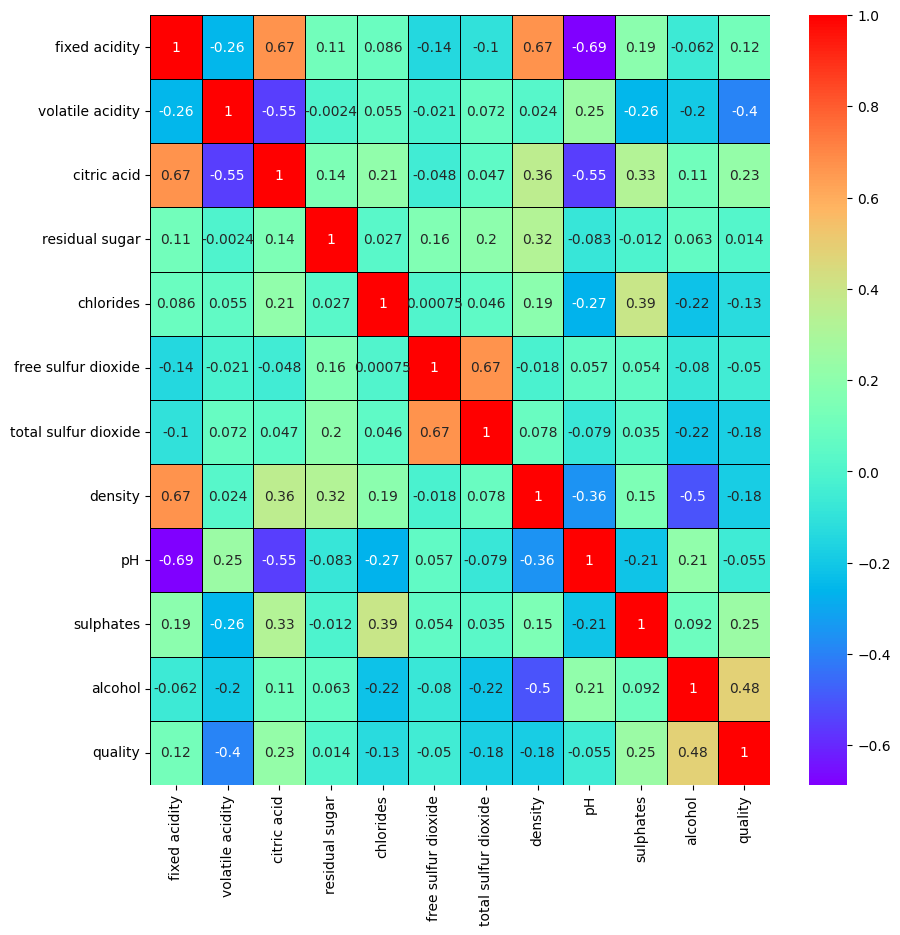

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='rainbow', linecolor='black', linewidths=0.5, annot=True)
plt.show()

Дополнить картину корреляционной матрицы поможет построение матрицы из графиков зависимости всех полей друг от друга.

In [ ]:
fig = px.scatter_matrix(df,color='quality')
fig.show()

Из построенных матриц можно сделать следующие выводы:
* Сильная корреляция (0.67) зависимости фиксированной кислотности от содержания лимонной кислоты и плотности;
* Сильная корреляция (0.67) зависимости количества свободного диоксида серы от общего количества диоксида серы в вине;
* Умеренная корреляция (0.33, 0.39) зависимости количества сульфатов от общего количества лимонной кислоты и хлоридов;
* Умеренная корреляция (0.36, 0.32) зависимости плотности вина от общего количества лимонной кислоты и остаточного сахара;
* Сильная отрицательная корреляция (-0.69, -0,55) зависимости водородного показателя от фиксированой кислотности и содержания лимонной кислоты;
* Сильная отрицательная корреляция (-0,55) зависимости волатильной кислотности от содержания лимонной кислоты;
* Сильная отрицательная корреляция (-0.5) крепости вина от его плотности;
* Умеренная отрицательная корреляция (-0.36) зависимости водородного показателя от плотности вина.

##3.4. Подготовка к решению задачи кластеризации

Подготовка к решению задачи кластеризации включает в себя понижение размерности данных. Для понижения размерности данных также, предварительно, выполняется нормализация данных.

Декомпозиция данных применяется для наглядного отображения на графике данных с большим количеством компонентов, что облегчает процесс кластеризации.

Для сокращения разрядности данных используется метод главных компонент (Principal component analysis), для работы которого предпочтительно чтобы данные имели среднее значение 0 и дисперсию 1.

Из предварительного анализа следует что данные не соответствуют этим параметрам, поэтому перед выполнением понижением разрядности данные следует нормализовать. Рекомендуемых параметров можно добиться при помощи стандартного масштабирователя (StandardScaler) из библиотеки sklearn.

In [ ]:
scaler = StandardScaler()
scaledData = scaler.fit_transform(df)

pca = PCA(n_components=2)
decomposedData = pca.fit_transform(scaledData)

Перед выбором метода кластеризации следует произвести отображение данных с пониженной разрядностью на графике.

In [ ]:
decomposedDf = pd.DataFrame(data = decomposedData, columns = ['x', 'y'])

fig = px.scatter(decomposedDf, x='x', y='y')
fig.show()


Из графика видно что чётко выделить кластеры не получается. Также в силу специфики графика, можно сказать, что методы кластеризирующие данные не зная заранее количества кластеров (например, dbscan и его вариации), здесь не дадут приемлемых результатов, поэтому следует поспользоваться методами разбивающими данные на конкретное количество кластеров, с предварительным подсчётом коэффициента силуэта кластеров. Для кластеризации в дальнейшем используются следующие методы:

- Гауссово смешение (GaussianMixture)
- метод k средних (KMeans)
- Спектральная кластеризация (SpectralClustering)
- Кластеризация WARD (WARD Clustering)

##3.5. Применение методов кластеризации



Для начала следует определить оптимальное количество кластеров для каждого метода кластеризации. Для этого осуществляется перебор значений кластеров от 2 до 10, выполняется кластеризация методом для которого определяется оптимальное количество кластеров и, затем, производится вывод коэффициента силуэта. Обычно, чем значение коэффициента выше, тем лучшим считается разбиение данных на кластера.

In [ ]:
for i in range(2, 10):
  cluster =  GaussianMixture(n_components=i, random_state=0)
  cluster_labels = cluster.fit_predict(decomposedData)
  sil_avg = silhouette_score(decomposedData, cluster_labels)
  print('GaussianMixture sil_avg = %.2f with %d clusters' % (sil_avg, i))

for i in range(2, 10):
  cluster = KMeans(n_clusters=i, n_init=10, max_iter=500, random_state=0)
  cluster_labels = cluster.fit_predict(decomposedData)
  sil_avg = silhouette_score(decomposedData, cluster_labels)
  print('KMeans sil_avg = %.2f with %d clusters' % (sil_avg, i))

for i in range(2, 10):
  cluster = SpectralClustering(n_clusters=i, random_state=0)
  cluster_labels = cluster.fit_predict(decomposedData)
  sil_avg = silhouette_score(decomposedData, cluster_labels)
  print('SpectralClustering sil_avg = %.2f with %d clusters' % (sil_avg, i))

for i in range(2, 10):
  cluster = AgglomerativeClustering(n_clusters=i)
  cluster_labels = cluster.fit_predict(decomposedData)
  sil_avg = silhouette_score(decomposedData, cluster_labels)
  print('WARD Clustering sil_avg = %.2f with %d clusters' % (sil_avg, i))

GaussianMixture sil_avg = 0.40 with 2 clusters
GaussianMixture sil_avg = 0.34 with 3 clusters
GaussianMixture sil_avg = 0.35 with 4 clusters
GaussianMixture sil_avg = 0.34 with 5 clusters
GaussianMixture sil_avg = 0.32 with 6 clusters
GaussianMixture sil_avg = 0.28 with 7 clusters
GaussianMixture sil_avg = 0.31 with 8 clusters
GaussianMixture sil_avg = 0.31 with 9 clusters
KMeans sil_avg = 0.40 with 2 clusters
KMeans sil_avg = 0.36 with 3 clusters
KMeans sil_avg = 0.36 with 4 clusters
KMeans sil_avg = 0.34 with 5 clusters
KMeans sil_avg = 0.35 with 6 clusters
KMeans sil_avg = 0.33 with 7 clusters
KMeans sil_avg = 0.33 with 8 clusters
KMeans sil_avg = 0.33 with 9 clusters
SpectralClustering sil_avg = 0.56 with 2 clusters
SpectralClustering sil_avg = 0.40 with 3 clusters
SpectralClustering sil_avg = 0.38 with 4 clusters
SpectralClustering sil_avg = 0.35 with 5 clusters
SpectralClustering sil_avg = 0.30 with 6 clusters
SpectralClustering sil_avg = 0.28 with 7 clusters
SpectralClustering s

Как следует из вывода выше, для всех методов наиболее оптимальное количество кластеров равняется двум. С учётом этого можно перейти к кластеризации и подготовке данных к отображению. Для удобства все данные после кластеризации представляются в виде dataFrame с полями:

- 'x' - первая компонента набора данных после понижения разрядности;
- 'y' - вторая компонента набора данных после понижения разрядности;
- 'Cluster' - метка кластера к которому алгоритм кластеризации отнёс данные в записи;

In [ ]:
df_GaussianMixture = decomposedDf
df_KMeans = decomposedDf
df_SpectralClustering = decomposedDf
df_WARDClustering = decomposedDf

GaussianMixtureClusterization = GaussianMixture(n_components=2, random_state=0)
KMeansClusterization = KMeans(n_clusters=2, n_init=10, max_iter=500, random_state=0)
SpectralClusteringClusterization = SpectralClustering(n_clusters=2, random_state=0)
WARDClusteringClusterization = AgglomerativeClustering(n_clusters=2)

y_GaussianMixture = GaussianMixtureClusterization.fit_predict(decomposedData)
y_KMeans = KMeansClusterization.fit_predict(decomposedData)
y_SpectralClustering = SpectralClusteringClusterization.fit_predict(decomposedData)
y_WARDClustering = WARDClusteringClusterization.fit_predict(decomposedData)

df_GaussianMixture['Cluster'] = y_GaussianMixture
df_KMeans['Cluster'] = y_KMeans
df_SpectralClustering['Cluster'] = y_SpectralClustering
df_WARDClustering['Cluster'] = y_WARDClustering

In [ ]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Кластеризация GaussianMixture", "Кластеризация KMeans", "Кластеризация SpectralClustering", "Кластеризация WARDClustering"))

fig.add_trace(
    px.scatter(df_GaussianMixture,'x', 'y', color='Cluster').data[0],
    row=1, col=1
)

fig.add_trace(
    px.scatter(df_KMeans,'x', 'y', color='Cluster').data[0],
    row=1, col=2
)

fig.add_trace(
    px.scatter(df_SpectralClustering,'x', 'y', color='Cluster').data[0],
    row=2, col=1
)

fig.add_trace(
    px.scatter(df_WARDClustering,'x', 'y', color='Cluster').data[0],
    row=2, col=2
)

fig.update_layout(height=600, width=800, title_text="Кластеризация")
fig.show()

Как следует из графиков, кластеризация всеми выбранными методами дала одинаковый результат и в целом выполнена хорошо.

##3.6 Оценка и визуализация результатов

Для проверки того насколько хорошо полученные кластеры накладываются на реальные данные, следует выполнить построение графика с данными после понижения разрядности и наложением на них качества вина и сравнить с результатами кластеризации.

In [ ]:
fig = px.scatter(decomposedDf, x='x', y='y', color=df['quality'], color_continuous_scale='jet', template='plotly_dark')
fig.show()

In [ ]:
fig = px.scatter(df_GaussianMixture, x='x', y='y', color='Cluster', color_continuous_scale='jet', template='plotly_dark')
fig.show()

Как видно из приведённых выше графиков, полученные кластеры достаточно хорошо накладываются на вина хорошего качества (7-8) и низкого качества (3-4), при этом вина среднего качества (5-6) примерно равномерно распределены по кластерам. Полученный результат совпадает с выводами о взаимосвязи качества с остальными параметрами полученными в ходе исследовательского анализа данных.